---
title: "의사결정나무 | 작동원리"
author: "강신성"
date: "2023-11-16"
categories: [python, tree]
---




> 의사결정나무가 작동하는 원리에 대해서 알아보자!

## 1. 라이브러리 imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython
import sklearn.tree

#---#
import warnings
warnings.filterwarnings('ignore')

## 2. 원리

### **A. `max_depth`**
---




> 얼만큼 깊게 나눌 것이냐???를 결정한다. 이 말을 이해해보자.

`-` **Data**

In [2]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:100]
temp.sort()
eps = np.random.randn(100)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})
df_train

,temp,sales
0,-4.1,10.900261
1,-3.7,14.002524
2,-3.0,15.928335
3,-1.3,17.673681
4,-0.5,19.463362
...,...,...
95,12.4,54.926065
96,13.4,54.716129
97,14.7,56.194791
98,15.0,60.666163


In [3]:
## 일단 늘 했던 것처럼...
## step1
X = df_train[['temp']]
y = df_train['sales']
## step2
predictr = sklearn.tree.DecisionTreeRegressor(max_depth=1) ## NEW!
## step3 
predictr.fit(X,y) 
## step4 -- pass 
# predictr.predict(X) 

DecisionTreeRegressor(max_depth=1)

`-` 결과를 시각화

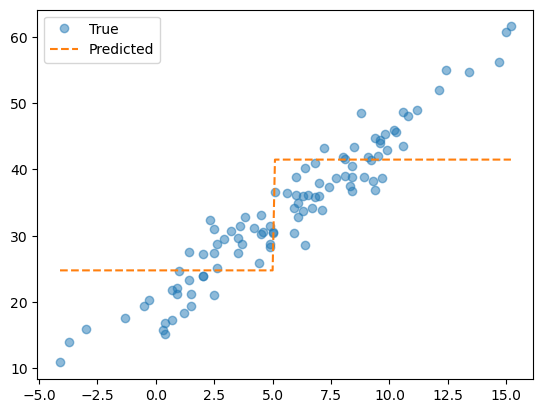

In [4]:
plt.plot(X, y, 'o', alpha = 0.5, label = 'True')
plt.plot(X, predictr.predict(X), '--', label = 'Predicted')
plt.legend()
plt.show()

> 5.0정도를 기준으로 계단이 뚝 끊긴 모습이다.

기존에는 막 이래저래 왔다갔다 하면서 오버피팅이 되는 모습이었는데, `max_depth = 1`옵션을 추가하니 뚝 끊겨서 값이 산정된다. 어떤 원리인지 알겠는가...?

`-` **`tree`** 시각화

[Text(0.5, 0.75, 'x[0] <= 5.05\nsquared_error = 111.946\nsamples = 100\nvalue = 33.973'),
 Text(0.25, 0.25, 'squared_error = 34.94\nsamples = 45\nvalue = 24.788'),
 Text(0.75, 0.25, 'squared_error = 49.428\nsamples = 55\nvalue = 41.489')]

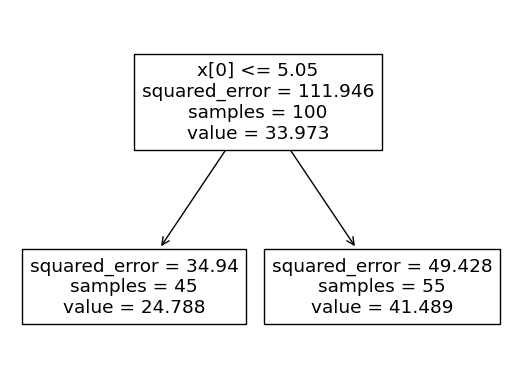

In [5]:
sklearn.tree.plot_tree(predictr)

> *의사결정나무는 이런 방식으로 적합을 한다!!*

적당한 $x$값을 기준으로 데이터를 나눈 뒤, 각 구간에 해당하는 녀석들의 $y$값 평균으로 예측해버린다!

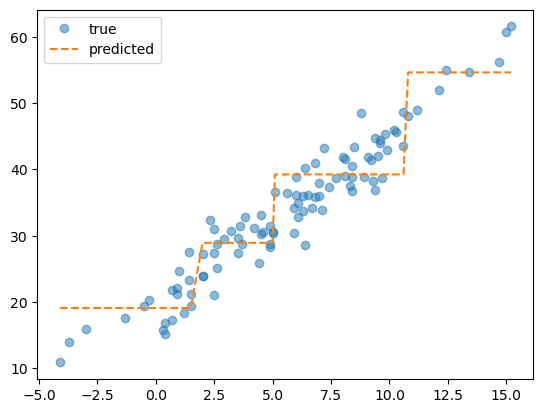

In [6]:
## 그럼 max_depth가 2라면???
## step1
X = df_train[['temp']]
y = df_train['sales']
## step2
predictr = sklearn.tree.DecisionTreeRegressor(max_depth=2)
## step3 
predictr.fit(X,y) 
## step4 -- pass 
# predictr.predict(X) 

plt.plot(X, y, 'o', label = 'true', alpha = 0.5)
plt.plot(X, predictr.predict(X), '--', label = 'predicted')
plt.legend()

> 방금 전의 `tree_plot`을 기억하는가? 거기서 한 번 더 내려온 것(한 단계 더 깊게 적합)이 `max_depth = 2`이다!

### **B. 애니메이션**
---




> 아직도 잘 감이 오지 않는다면, `animation`을 이용해 `max_depth`에 따른 예측값의 변화를 시각화해보자.

In [7]:
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

In [8]:
def func(frame):
    ax = fig.gca()
    ax.clear()
    predictr = sklearn.tree.DecisionTreeRegressor(max_depth = frame+1)
    predictr.fit(X, y)
    ax.plot(X, y, 'o', alpha = 0.5, label = 'True')
    ax.plot(X, predictr.predict(X), '--', label = 'Predicted')
    ax.set_title('max_depth = {}'.format(str(frame+1)))

In [9]:
ani = matplotlib.animation.FuncAnimation(
    fig,
    func,
    frames = 10
)

display(IPython.display.HTML(ani.to_jshtml()))

> `max_depth`의 값이 커질수록 계단의 구간이 많아지더니 점을 따라가기 시작했다...

###### 코드를 쉽게 쓰기 위해서 `func`에다 `fitting`하는 것까지 넣어줬지만, 원래는 외부에서 `fitting`된 녀석을 넣어주는 게 리소스 절감에 용이하긴 하다...

### **C. 분할을 결정하는 기준?**
---




그럼 그 계단의 경계는 어떻게 결정되는 걸까?

In [10]:
predictr.score(X, y)

0.8561424389856722

In [11]:
y_hat = predictr.predict(X)
sklearn.metrics.r2_score(y, y_hat)  ## 딱히 라이브러리를 들여오지 않아도 나오네...

0.8561424389856722

> 회귀모형이 전체 변동 중 얼마만큼을 설명했는지를 나타내는 $R^2$를 좋은 분할을 판단하는 기준으로 사용한다.

즉, 가능한 계단의 경계값들 중 $R^2$이 가장 높은 값이 분할로 결정된다!!

`-` 이 과정을 구현해보자.

In [26]:
def fit_predict(X, y, c) :
    """
    X와 y, 분할할 구간을 넣어주면 max_depth = 1일 때의 구간에 따른 예측값을 반환하는 함수.
    """
    X = np.array(X).reshape(-1)  ## 1차원으로 깨줌
    y = np.array(y)
    yhat = y*0  ## 초기값 배정
    yhat[X<=c] = y[X<=c].mean()  ## bool list로 슬라이싱
    yhat[X>c] = y[X>c].mean()
    
    return yhat

Text(0.5, 1.0, 'R-quared = 0.6167')

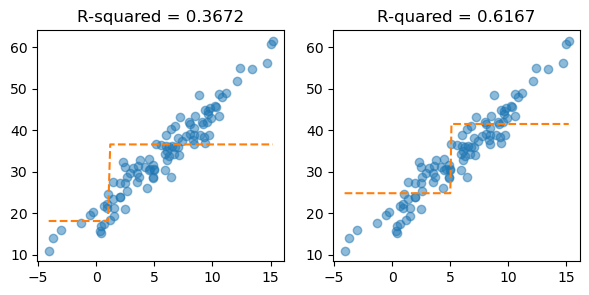

In [30]:
yhat_bad = fit_predict(X, y, 1)
yhat_good = fit_predict(X, y, 5)

fig, ax = plt.subplots(1,2, figsize = (7,3))
ax[0].plot(X, y, 'o', alpha = 0.5)
ax[0].plot(X, yhat_bad, '--')
ax[0].set_title('R-squared = {}'.format(round(sklearn.metrics.r2_score(y, yhat_bad), 4)))
ax[1].plot(X, y, 'o', alpha = 0.5)
ax[1].plot(X, yhat_good, '--')
ax[1].set_title('R-quared = {}'.format(round(sklearn.metrics.r2_score(y, yhat_good), 4)))

> `c`의 값이 5일 때, $R^2$의 값이 더 클 뿐만 아니라, 예측한 값이 더 직관적으로 좋아보인다.

`-` 그래서 트리가 `max_depth = 1`일 경우 분할을 결정하는 방법! ~= 노가다...~

1. 적당한 $c$를 고른다.
2. 분할 $(-\infty, c), [c, \infty)$를 생성하고 `yhat`을 계산한다.
3. `r2_score(y, yhat)`을 계산하고 기록한다.
4. 상기 과정을 무한반복한 뒤, `r2_score(y, yhat)`의 값을 가장 작게 만드는 $c$를 구간으로 택한다.

In [33]:
fit_predict??

Signature: fit_predict(X, y, c)
Source:   
def fit_predict(X, y, c) :
    """
    X와 y, 분할할 구간을 넣어주면 max_depth = 1일 때의 구간에 따른 예측값을 반환하는 함수.
    """
    X = np.array(X).reshape(-1)  ## 1차원으로 깨줌
    y = np.array(y)
    yhat = y*0  ## 초기값 배정
    yhat[X<=c] = y[X<=c].mean()  ## bool list로 슬라이싱
    yhat[X>c] = y[X>c].mean()
    
    return yhat
File:      c:\users\hollyriver\appdata\local\temp\ipykernel_8144\486783211.py
Type:      function

In [49]:
cuts = np.arange(-5, 15)
fig = plt.figure()
def func(frame) :
    ax = fig.gca()
    ax.clear()
    yhat = fit_predict(X, y, cuts[frame])
    
    ax.plot(X, y, 'o', alpha = 0.5, label = 'True')
    ax.plot(X, yhat, '--', label = 'Predicted')
    ax.set_title(f'c = {cuts[frame]},  R-squared = {round(sklearn.metrics.r2_score(y, yhat), 4)}')
    ax.legend()

<Figure size 640x480 with 0 Axes>

In [50]:
ani = matplotlib.animation.FuncAnimation(
    fig,
    func,
    frames = len(cuts)
)

In [56]:
display(IPython.display.HTML(ani.to_jshtml()))

> 요런 느낌으로다가...

`-` 그럼 `tree`가 찾은 값 5.05를 우리가 직접 찾아보자.

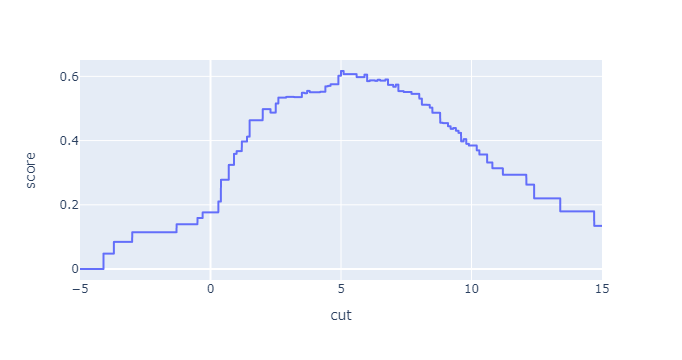

In [64]:
cuts = np.arange(-5, 15, 0.001).round(5)
scores = np.array([sklearn.metrics.r2_score(y, fit_predict(X, y, c)) for c in cuts])
pd.DataFrame({'cut':cuts, 'score':scores}).plot.line(x = 'cut', y = 'score', backend = 'plotly')

In [65]:
cuts[scores.argmax()]  ## R에서의 which()와 비슷한 느낌의 코드

5.0

> `max_depth = 2`인 경우는 `max_depth = 1`의 결과로 발생한 2개의 조각을 각각 전체 자료로 생각하고, `max_depth = 1`일 때의 분할방법을 반복적용한다.
>
> `X.columns == ['temp', 'type']`와 같은 경우라면, 설명변수를 하나씩 고정하여 각각 최적의 분할을 생성하고, `r2_score`관점에서 가장 우수한 설명변수를 선택한다.(즉, 가장 중요한 설명변수가 최우선적으로 고려된다.)

## 3. 토론

`-` 의사결정나무 vs 선형모형 !!!

* 의사결정나무의 장점

1. 시각화가 유리하다, 설명력이 좋다.
2. 특성(feature)의 중요도를 파악하기 용이하다(그야 가장 우수한 설명변수가 `depth`에 따라 최우선적으로 고려되니까.)
3. $\textbf{y} \sim \textbf{X}$ 사이에 존재하는 비선형성을 간단히 모델링할 수 있다.
4. 모형에 대한 가정들이 필요없다.(**Nonparametric Model**)

* 의사결정나무의 단점 : **오버피팅이 일어나기 너무 쉽다**

`-` 자잘한 개념들(`option`)

**최소 샘플 분할(`min_samples_split`)**

* 노드를 분할하기 위한 최소 샘플 수.
* 과소적합(수를 줄임) 및 과적합(수를 늘림) 조절 가능

**가지치기(Pruning)**

* 트리의 불필요한 부분을 제거(아래로 뻗어나가는 가지 제거)하여 과적합 방지 및 모델 성능 향상에 도움.

**정보 이득(Information Gain)**

* 분할 전후의 엔트로피 차이를 측정(좀 많이 굉장히 어려운 개념임)
* 높은 정보 이득은 더 좋은 분할을 의미

**지니 불순도(Gini Impurity)**

* 노드의 순도 측정 지표, 낮은 지니 불순도는 높은 클래스 순도를 의미

> 결국 "트리를 어디까지 성장시킬래?"에 대한 이론적인 명확한 기술은 없다... Nonparametric Model이니까 정답이 없음...

* 의사결정나무를 응용한 다양한 방법(<span style='color:grey;size:10'>너무 많아요, 진짜</span>)들이 개발되었고, 모든 방법들의 원리를 세세하게 파헤치는 건 비효율적이다...

* 그러한 다양한 방법들을 적당히 분류해보면 대체로 배깅, 랜덤포레스트, 부스팅 계열~(게다가 이중 여러가지를 포함하기도 함)~로 나뉜다. 앞으론 이 세 분류에 대한 공통적 아이디어를 파악해보도록 하자.